<a href="https://colab.research.google.com/github/Wistral/ci-test/blob/master/Google_%E4%BA%91%E7%AB%AF%E7%A1%AC%E7%9B%98demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

此笔记本提供了用于加载和保存外部来源中的数据的方法。

# 本地文件系统

## 从本地文件系统上传文件

<code>files.upload</code> 会返回已上传文件的字典。
此字典的键为文件名，值为已上传的数据。

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

## 将文件下载到本地文件系统

<code>files.download</code> 会通过浏览器将文件下载到本地计算机。


In [0]:
from google.colab import files

with open('example.txt', 'w') as f:
  f.write('some content')

files.download('example.txt')

# Google 云端硬盘

您可以通过多种方式访问 Google 云端硬盘中的文件，其中包括：
- 在运行时的虚拟机中装载 Google 云端硬盘
- 对 Drive API 使用封装容器（例如 <a href="https://gsuitedevs.github.io/PyDrive/docs/build/html/index.html">PyDrive</a>）
- 使用<a href="https://developers.google.com/drive/v3/web/about-sdk">原生 REST API</a>



每个方法的示例如下所示。

## 在本地装载 Google 云端硬盘

以下示例展示了如何使用授权代码在您的运行时上装载 Google 云端硬盘，以及如何在那里写入和读取文件。一旦执行，您便可以在 <a href="https://drive.google.com/">https://drive.google.com/</a> 看到相应的新文件 &#40;<code>foo.txt</code>&#41;。

请注意，此操作仅支持读取、写入和移动文件；要程序化地修改共享设置或其他元数据，请使用以下某一其他选项。

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!ls drive/My\ Drive

'Colab Notebooks'   train_part0.tfrecord
 images.npz	    数学建模竞赛中、英文献检索方法与技巧.pdf
 labels.npz


In [15]:
import numpy as np
labels = np.load('drive/My Drive/labels.npz')
images = np.load('drive/My Drive/images.npz')


NameError: ignored

In [22]:
print(len(labels),len(images))
import matplotlib.pyplot as plt

char_map = {
    i: e
    for i,e in enumerate(["Reimu", "Marisa", "Koishi",
         "Remilia", "Sakuya", "Cirno", "Clownpiece", "Flandre", "Patchouli",
           "Yuyuko", "Hina", "Kaguya", "Yukari", "Yuuka", "Eirin", "Kogasa", "Youmu", "Sanae",
           "Utsuho", "Satori"])
}

2997 2997


Eirin


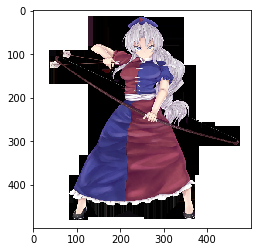

In [32]:
import random


def show_im_by_index(i):
  print(char_map[labels[i]])
  plt.imshow(images[i])

show_im_by_index(random.randint(0,2997))

In [0]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.


In [42]:
# !apt update
# !apt install htop
import tensorflow as tf
tf.__version__
print(tf.test.is_built_with_cuda(),
  tf.test.is_gpu_available())


True False


## Drive REST API

要使用 Drive API，我们必须先进行身份验证，然后构建 API 客户端。


In [0]:
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

借助此客户端，我们可以使用 <a href="https://developers.google.com/drive/v3/reference/">Google Drive API 参考文档</a>中列出的任何函数。后面有示例。


### 使用来自 Python 的数据创建新的 Google 云端硬盘文件

首先，创建要上传的本地文件。

In [0]:
with open('/tmp/to_upload.txt', 'w') as f:
  f.write('my sample file')

print('/tmp/to_upload.txt contains:')
!cat /tmp/to_upload.txt

/tmp/to_upload.txt contains:
my sample file

使用 <a href="https://developers.google.com/drive/v3/reference/files/create"><code>files.create</code></a> 方法上传此文件。如需了解文件上传的有关详情，请参阅<a href="https://developers.google.com/drive/v3/web/manage-uploads">开发者文档</a>。

In [0]:
from googleapiclient.http import MediaFileUpload

file_metadata = {
  'name': 'Sample file',
  'mimeType': 'text/plain'
}
media = MediaFileUpload('/tmp/to_upload.txt', 
                        mimetype='text/plain',
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id')))

File ID: 1Cw9CqiyU6zbXFD9ViPZu_3yX-sYF4W17


执行上述单元格后，您会在 <a href="https://drive.google.com/">https://drive.google.com/</a> 看到一个名为“Sample file”的新文件。

### 从 Google 云端硬盘文件中将数据下载到 Python 中

下载我们在前面上传的文件。

In [0]:
file_id = created.get('id')

import io
from googleapiclient.http import MediaIoBaseDownload

request = drive_service.files().get_media(fileId=file_id)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False
while done is False:
  # _ is a placeholder for a progress object that we ignore.
  # (Our file is small, so we skip reporting progress.)
  _, done = downloader.next_chunk()

downloaded.seek(0)
print('Downloaded file contents are: {}'.format(downloaded.read()))

Downloaded file contents are: b'my sample file'


要下载其他文件，请将上述 <code>file&#95;id</code> 设为此文件的 ID，此 ID 大致如下：1uBtlaggVyWshwcyP6kEI-y&#95;W3P8D26sz。

# Google 表格

以下示例使用开源 <a href="https://github.com/burnash/gspread"><code>gspread</code></a> 库与 Google 表格进行互动。

首先，使用 <code>pip</code> 安装软件包。

In [0]:
!pip install --upgrade --quiet gspread

导入库，进行身份验证，然后创建 Google 表格接口。

In [0]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

以下是一些 <code>gspread</code> 示例。如需查看其他示例，请参阅 <a href="https://github.com/burnash/gspread#more-examples"><code>gspread</code> GitHub 页面</a>。

## 正在使用来自 Python 的数据创建新工作表

In [0]:
sh = gc.create('My cool spreadsheet')

执行上述单元格后，您会在 <a href="https://sheets.google.com/">https://sheets.google.com</a> 看到一个名为“My cool spreadsheet”的新电子表格。

打开新工作表，然后添加一些随机数据。

In [0]:
worksheet = gc.open('My cool spreadsheet').sheet1

cell_list = worksheet.range('A1:C2')

import random
for cell in cell_list:
  cell.value = random.randint(1, 10)

worksheet.update_cells(cell_list)

{'spreadsheetId': '1dsQeN0YzXuM387l_CuyEbsYzL2ew9TJFzR-E-RQnwxs',
 'updatedCells': 6,
 'updatedColumns': 3,
 'updatedRange': 'Sheet1!A1:C2',
 'updatedRows': 2}

## 从工作表中将数据作为 Pandas DataFrame 下载到 Python 代码中

读回我们在上面插入的随机数据，然后将结果转换为 <a href="https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html">Pandas DataFrame</a>。

In [0]:
worksheet = gc.open('My cool spreadsheet').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
print(rows)

import pandas as pd
pd.DataFrame.from_records(rows)

[['6', '3', '4'], ['7', '2', '1']]


,0,1,2
0,6,3,4
1,7,2,1


# Google Cloud Storage &#40;GCS&#41;

要将 Colaboratory 与 GCS 结合使用，您需要创建 <a href="https://cloud.google.com/storage/docs/projects">Google Cloud 项目</a>或使用已有项目。

在下面指定项目 ID：

In [0]:
project_id = 'Your_project_ID_here'

GCS 中的文件包含在<a href="https://cloud.google.com/storage/docs/key-terms#buckets">存储分区</a>中。

存储分区的名称必须是全局唯一的，因此我们在此处生成一个。

In [0]:
import uuid
bucket_name = 'colab-sample-bucket-' + str(uuid.uuid1())

要访问 GCS，我们必须进行身份验证。

In [0]:
from google.colab import auth
auth.authenticate_user()

可通过 <code>gsutil</code> 命令行实用程序或原生 Python API 访问 GCS。

## `gsutil`

首先，我们通过使用 <code>gcloud</code> 将 <code>gsutil</code> 配置为使用我们在上面指定的项目。

In [0]:
!gcloud config set project {project_id}

Updated property [core/project].


创建要上传的本地文件。

In [0]:
with open('/tmp/to_upload.txt', 'w') as f:
  f.write('my sample file')

print('/tmp/to_upload.txt contains:')
!cat /tmp/to_upload.txt

/tmp/to_upload.txt contains:
my sample file

设置一个接收我们上传的文件（<a href="https://cloud.google.com/storage/docs/gsutil/commands/mb">文档</a>）的存储分区。

In [0]:
!gsutil mb gs://{bucket_name}

Creating gs://colab-sample-bucket-44971372-baaf-11e7-ae30-0242ac110002/...


将此文件复制到我们的新存储分区（<a href="https://cloud.google.com/storage/docs/gsutil/commands/cp">文档</a>）。

In [0]:
!gsutil cp /tmp/to_upload.txt gs://{bucket_name}/

Copying file:///tmp/to_upload.txt [Content-Type=text/plain]...
/ [1 files][   14.0 B/   14.0 B]                                                
Operation completed over 1 objects/14.0 B.                                       


转储新复制文件的内容，以确保一切正常（<a href="https://cloud.google.com/storage/docs/gsutil/commands/cat">文档</a>）。


In [0]:
!gsutil cat gs://{bucket_name}/to_upload.txt

my sample file

In [0]:
#@markdown 上传完毕后，数据将显示在项目的 Cloud Console Storage 浏览器中：
print('https://console.cloud.google.com/storage/browser?project=' + project_id)

https://console.cloud.google.com/storage/browser?project=Your_project_ID_here


最后，我们将下载刚才在以上示例中上传的文件。此操作就像在 <code>gsutil cp</code> 命令中颠倒顺序一样简单。

In [0]:
!gsutil cp gs://{bucket_name}/to_upload.txt /tmp/gsutil_download.txt
  
# 输出结果，以确保传输按预期运行。
!cat /tmp/gsutil_download.txt

Copying gs://colab-sample-bucket483f20dc-baaf-11e7-ae30-0242ac110002/to_upload.txt...
/ [1 files][   14.0 B/   14.0 B]                                                
Operation completed over 1 objects/14.0 B.                                       
my sample file

## Python API

这些代码段基于<a href="https://github.com/GoogleCloudPlatform/storage-file-transfer-json-python/blob/master/chunked_transfer.py">一个大型示例</a>，该示例展示了 API 的其他用途。

首先，我们创建服务客户端。

In [0]:
from googleapiclient.discovery import build
gcs_service = build('storage', 'v1')

创建要上传的本地文件。

In [0]:
with open('/tmp/to_upload.txt', 'w') as f:
  f.write('my sample file')

print('/tmp/to_upload.txt contains:')
!cat /tmp/to_upload.txt

/tmp/to_upload.txt contains:
my sample file

在上面指定的项目中创建一个存储分区。

In [0]:
# 使用与上述 gsutil 示例不同的全局唯一存储分区名称。
import uuid
bucket_name = 'colab-sample-bucket-' + str(uuid.uuid1())

body = {
  'name': bucket_name,
  # For a full list of locations, see:
  # https://cloud.google.com/storage/docs/bucket-locations
  'location': 'us',
}
gcs_service.buckets().insert(project=project_id, body=body).execute()
print('Done')

Done


将文件上传到新创建的存储分区。

In [0]:
from googleapiclient.http import MediaFileUpload

media = MediaFileUpload('/tmp/to_upload.txt', 
                        mimetype='text/plain',
                        resumable=True)

request = gcs_service.objects().insert(bucket=bucket_name, 
                                       name='to_upload.txt',
                                       media_body=media)

response = None
while response is None:
  # _ is a placeholder for a progress object that we ignore.
  # (Our file is small, so we skip reporting progress.)
  _, response = request.next_chunk()

print('Upload complete')

Upload complete


In [0]:
#@markdown 上传完毕后，数据将显示在项目的 Cloud Console Storage 浏览器中：
print('https://console.cloud.google.com/storage/browser?project=' + project_id)

https://console.cloud.google.com/storage/browser?project=Your_project_ID_here


下载我们刚才上传的文件。

In [0]:
from apiclient.http import MediaIoBaseDownload

with open('/tmp/downloaded_from_gcs.txt', 'wb') as f:
  request = gcs_service.objects().get_media(bucket=bucket_name,
                                            object='to_upload.txt')
  media = MediaIoBaseDownload(f, request)

  done = False
  while not done:
    # _ is a placeholder for a progress object that we ignore.
    # (Our file is small, so we skip reporting progress.)
    _, done = media.next_chunk()

print('Download complete')

Download complete


检查下载的文件。


In [0]:
!cat /tmp/downloaded_from_gcs.txt

my sample file